In [1]:
import pandas as pd

In [ ]:
header = ['DESTINATION','CORE_TIME','POLLER_TIME','TARGET_ID',
           'POLICY_ID','POLICY_TYPE','DETECTED_SEVERITY','PROPAGATED_SEVERITY',
           'LOW_THRESHOLD','MEASURED_VALUE','HIGH_THRESHOLD','PROPAGATED_FLAG','EVENT_CODE',
           'METRIC_NAME','RECON_ID','BUS_ID','PARENT_BUS_ID','NEW_BUS_ID','RECONCILIATION_NUM',
           'DEVICE_TYPE','OPERATING_SYSTEM','RECONCILIATION_ID','SITE','TYPE_NAME',
           'IS_VIRTUAL','PARENT_TARGET_ID','MONITOR_DESC', 'CRAP']
events = pd.read_csv("event-logs-merged.csv", names = header)

In [ ]:
events = events[['CORE_TIME','TARGET_ID','PARENT_TARGET_ID', 'MONITOR_DESC','DETECTED_SEVERITY',
        'PROPAGATED_SEVERITY','MEASURED_VALUE','LOW_THRESHOLD',
        'HIGH_THRESHOLD','PROPAGATED_FLAG','EVENT_CODE',
        'RECON_ID', 'NEW_BUS_ID', 'RECONCILIATION_NUM', 'DEVICE_TYPE', 'OPERATING_SYSTEM',
        'RECONCILIATION_ID','SITE','TYPE_NAME','IS_VIRTUAL']]

In [ ]:
events.describe()

In [ ]:
events = events.reset_index()

In [ ]:
print(events['EVENT_CODE'].unique())
print(len(events['NEW_BUS_ID'].unique()))
print(events['OPERATING_SYSTEM'].unique())

In [38]:
header = ['INCIDENT_ID','SUBMIT_DATE','SUBMIT_DATE_MS','BUS_ID','EVENT_CODE','RECON_ID','EVENT_CODE_ID']
incident = pd.read_csv("incident-details-merged.csv", names = header)

In [6]:
incident['SUBMIT_DATE']=pd.to_datetime(incident["SUBMIT_DATE"], format='%d-%b-%Y %H:%M:%S')

In [24]:
incident['WORKDAY']=incident['SUBMIT_DATE'].dt.weekday
incident['HOUR']=incident['SUBMIT_DATE'].dt.hour

In [44]:
incident['SUBMIT_DATE'].min()

'1-Apr-2019 00:02:40'

In [25]:
df = pd.DataFrame(incident.groupby(['WORKDAY','HOUR'])['INCIDENT_ID'].count()) 

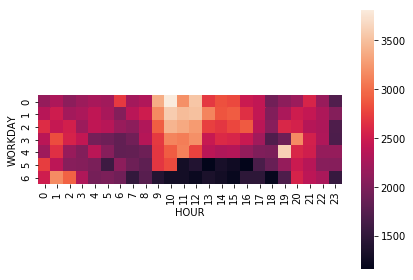

In [36]:
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn.apionly as sns
import matplotlib.pyplot as plt

# create dataframe with datetime as index and aggregated (frequency) values
# date = pd.date_range('2017-02-23', periods=10*12, freq='2h')
# freq = np.random.poisson(lam=2, size=(len(date)))
# df = pd.DataFrame({"freq":freq}, index=date)

# add a column hours and days
# df["hours"] = incident["SUBMIT_DATE"].hour
# df["days"] = incident["SUBMIT_DATE"].day
# create pivot table, days will be columns, hours will be rows
piv = pd.pivot_table(df, values="INCIDENT_ID",index=["WORKDAY"], columns=["HOUR"], fill_value=0)
#plot pivot table as heatmap using seaborn
# plt.figure(figsize=(15,20))
ax = sns.heatmap(piv, square=True)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
plt.show()

In [ ]:
start = events["CORE_TIME"].min()
end = events["CORE_TIME"].max()

In [ ]:
BUFFER = 120*60*60
incidents_core = incident[(incident['SUBMIT_DATE_MS'] < end + BUFFER)
         & (incident['SUBMIT_DATE_MS'] > start)
         & (incident['EVENT_CODE'].isin(events_core['EVENT_CODE']))]

In [ ]:
incidents_core

In [ ]:
# might_have_something = incidents_core.merge(events, left_on=['EVENT_CODE','RECON_ID'], 
#                                             right_on = ['EVENT_CODE','RECON_ID'], how="inner")
might_have_something = incidents_core.merge(events, left_on=['RECON_ID'], 
                                            right_on = ['RECON_ID'], how="inner")

In [ ]:
might_have_something

In [ ]:
print(len(incidents_core['INCIDENT_ID'].unique()))
print(len(might_have_something['INCIDENT_ID'].unique()))

In [ ]:
might_have_something['GAP'] = (might_have_something['SUBMIT_DATE_MS'] - might_have_something['CORE_TIME'])/60/60

In [ ]:
might_have_something['GAP'].describe()

In [ ]:
might_have_something[(might_have_something['GAP'] < 49) & (might_have_something['GAP'] > 0)].sort_values("GAP")

In [ ]:
print(might_have_something["index"].unique().shape)
print(might_have_something["INCIDENT_ID"].unique().shape)

In [ ]:
events_core["lead_to_event"] = events["index"].isin(might_have_something["index"])

In [ ]:
print(events_core['metric_name'].unique().shape)
print(events_core['event_code'].unique().shape)
print(events_core['recon_id'].unique().shape)

In [ ]:
print(might_have_something['metric_name'].unique())
print(might_have_something['event_code'].unique())
print(might_have_something['recon_id'].unique().shape)

In [ ]:
def extactReconFromCluster(clusters, threshold):
    recons_in_cluster = set()
    for cluster in clusters:
        if (len(cluster) > threshold):
            for event in cluster:
                recons_in_cluster.add(event["RECON_ID"])
    return recons_in_cluster

In [ ]:
# extract_1 = extactReconFromCluster(event_clusters_5,1)
# extract_5 = extactReconFromCluster(event_clusters_5,5)
# extract_8 = extactReconFromCluster(event_clusters_5,8)
# extract_15 = extactReconFromCluster(event_clusters_5,15)
# print(len(extract_1))
# print(len(extract_5))
# print(len(extract_8))
# print(len(extract_15))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTENC

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(events_core.drop(['index','lead_to_event'], axis=1), 
                                                  events_core['lead_to_event'],
                                                  test_size = .1,
                                                  random_state=12)

In [ ]:
sm = SMOTENC(random_state=12, categorical_features=[3,4,5])
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)